## Pathways to Desistance Study

The Pathways to Desistance study ("Pathways study") was a multi-site study that followed 1,354 serious juvenile offenders, surveying them periodically from adolescence to young adulthood in Arizona and Pennsylvania between 2000 and 2010 (Mulvey, 2010). The surveys conducted covered six primary domains: (1) background characteristics, (2) indicators of individual functioning, (3) psychosocial development and attitudes, (4) family context, (5) personal relationships, and (6) community context (e.g., neighborhood conditions, personal capital, and community involvement). The aims of the study were to identify initial patterns of how serious adolescent offenders stop antisocial activity, to describe the role of social context and developmental changes in promoting these positive changes, and to compare the effects of sanctions and interventions in promoting these changes. (Mulvey, 2010). 

## Pathways to Desistance Data
The data collected over the course of the Pathways study is divided into eleven datasets, organized by recall period of the respondents. These datasets are cross-sectional, though given the uniformity of variables across datasets, it is relatively easy to construct time-series data by combining multiple datasets. 

For the purposes of our showcase, we have decided to evaluate the predictive power of early-onset behavioral issues, exposure to violence, and psychosocial maturity on likelihood of police contact for a given youth. We have decided to use the following variables from the datasets:
 - *Exposure to violence* (`S#EXPTOT`): Endorsed sum of times respondent was either the victim of or witness to violence. This measure was made from an adapted version of Exposure to Violence Inventory (ETV; Selner-O'Hagan, Kindlon, Buka, Raudenbush, & Earls, 1998). Respondents were asked six questions regarding victim status, seven questions regarding witnessing violence, and four questions about exposure to death (Mulvey, 2010).
 - *Early onset behavioral problems* (`S0NEARPRO`): This is the total count of early-onset behavioral problems reported by the respondent based on five questions. This measure was taken from Forth et al. (2013) and asked if the respondent had been in trouble before the age of 11 for cheating, stealing, being drunk/stoned, fighting, or disturbing class (Mulvey, 2010).
 - *Psychosocial Maturity* (`S#PSMI`): Mean score of respondent’s Psychosocial Maturity Inventory (PSMI Form D; Greenberger, Josselson, Knerr, & Knerr, 1974). This inventory examines identity, self-reliance, and work orientation through 30 questions. Each item is answered on a 4-point Likert scale.  Items are scored so that higher values correspond with higher maturity (Mulvey, 2010). This was the variable that addressed overall psychosocial maturity of respondents with the most clarity, which is why we decided to use it instead of other variables from the study.
 - *Police contact with respondent* (`S#PROJUS_PJPOLI`): This binary variable indicates whether respondent reports being picked up by police and accused of something in the recall period.
     - *Police contact with respondent, Number of times* (`S#PROJUS_PJPNUM`): §  The score for this variable describes the number of times, if any, the respondent indicates they were picked up by police and accused of something.

It is our intent to create these graphs for each 'wave' of the dataset. For the purposes of proof-of-concept, we have only created one iteration of the graphs, using the first recall dataset. 

In [1]:
## Prework: Stage Environment

import numpy as np
import pandas as pd
import graphviz as gv
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import csv
import seaborn as sns
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import pydotplus
import warnings

warnings.simplefilter('ignore')

In [2]:
## Load Initial Dataset
filename = 'S1month.csv'

# Create set variants
SAmonthraw = pd.read_csv(filename)
SAmonth = pd.read_csv(filename, na_values = [-202, -201, -101, -700, -300, -9, -8])   
SAmonthNA = SAmonth.dropna()
SAstatsonly = SAmonth.drop(['CASEID', 'LINEID'], axis=1)
## The na_values indicate the following:
##      -202: Partial interview, data missing
##      -201: Missed interview
##      -101: Not picked up by police during recall period
##      -700: Data missing due to bug in interview
##      -300: Too few answers for computation 
##      -9: Didn't Know
##      -8: Refused

In [3]:
## Display Summary Statistics
SAstatsonly.describe()

,S1PROJUS_PJPOLI,S1PROJUS_PJPNUM,S1PSMI,S1EXPTOT,S0NEARPRO
count,1260.000000,231.000000,1258.000000,1261.000000,1354.000000
mean,0.183333,1.311688,3.055199,1.448057,1.519941
std,0.387093,0.817096,0.462735,1.894404,1.191235
min,0.000000,1.000000,1.100000,0.000000,0.000000
25%,0.000000,1.000000,2.770000,0.000000,1.000000
50%,0.000000,1.000000,3.030000,1.000000,1.000000
75%,0.000000,1.000000,3.400000,2.000000,2.000000
max,1.000000,7.000000,4.000000,10.000000,5.000000


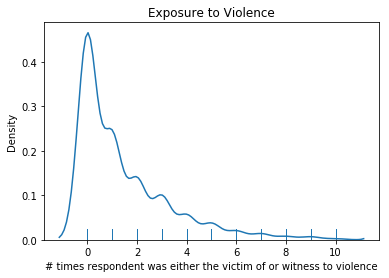

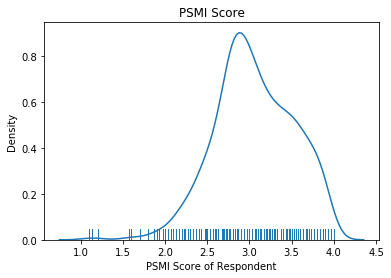

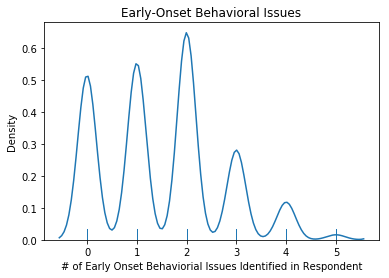

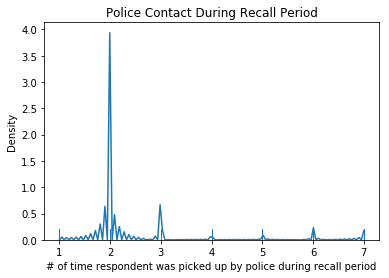

In [4]:
## Distribution of Variables: Density Plots

#Exposure to Violence
sns.distplot(SAmonth.S1EXPTOT, hist=False, rug=True);
plt.xlabel("# times respondent was either the victim of or witness to violence")
plt.ylabel("Density")
plt.title("Exposure to Violence")
plt.show()

#Psychosocial Maturity

sns.distplot(SAmonth.S1PSMI, hist=False, rug=True);
plt.xlabel("PSMI Score of Respondent")
plt.ylabel("Density")
plt.title("PSMI Score")
plt.show()

#Respondent's early-onset behavioral issues
sns.distplot(SAmonth.S0NEARPRO, hist=False, rug=True);
plt.xlabel("# of Early Onset Behaviorial Issues Identified in Respondent")
plt.ylabel("Density")
plt.title("Early-Onset Behavioral Issues")
plt.show()

#Respondent's Contact with Police
sns.distplot(SAmonth.S1PROJUS_PJPNUM, hist=False, rug=True);
plt.xlabel("# of time respondent was picked up by police during recall period")
plt.ylabel("Density")
plt.title("Police Contact During Recall Period")
plt.show()

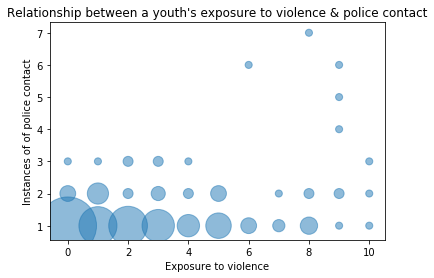

In [5]:
## Prework for Bubble Plot: Relationship between exposure to violence & Police Contact

count = 0
x_vals = []
y_vals = []
bsize = []
for i in SAmonth.S1EXPTOT.unique():
    for j in SAmonth.S1PROJUS_PJPNUM.unique():
            bubblesize = len(SAmonth[(SAmonth.S1EXPTOT == i) & (SAmonth.S1PROJUS_PJPNUM == j)])
            count += bubblesize
            x_vals.append(i)
            y_vals.append(j)
            bsize.append(bubblesize)

bsizescale = [n*50 for n in bsize]

# Create Bubble Plot: Relationship Between Exposure to Violence & Police Contact
plt.scatter(x_vals, y_vals, s=bsizescale, alpha=0.5)
plt.xlabel("Exposure to violence")
plt.ylabel("Instances of of police contact")
plt.title("Relationship between a youth's exposure to violence & police contact")
plt.show()

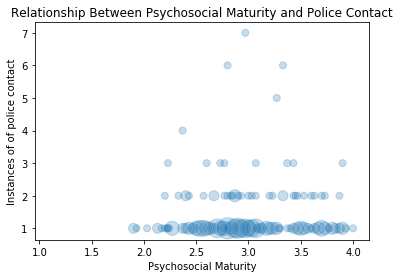

In [6]:
## Prework for Bubble Plot: Relationship between exposure to violence & police contact

count2 = 0
x_vals2 = []
y_vals2 = []
bsize2 = []
for i in SAmonth.S1PSMI.unique():
    for j in SAmonth.S1PROJUS_PJPNUM.unique():
            bubblesize2 = len(SAmonth[(SAmonth.S1PSMI == i) & (SAmonth.S1PROJUS_PJPNUM == j)])
            count2 += bubblesize2
            x_vals2.append(i)
            y_vals2.append(j)
            bsize2.append(bubblesize2)

bsizescale2 = [n*50 for n in bsize2]

# Create Bubble Plot: Relationship between Psychosocial Maturity and Police Contact

fig, ax = plt.subplots()
ax.scatter(x_vals2, y_vals2, s=bsizescale2, alpha=0.25)
plt.xlabel('Psychosocial Maturity')
plt.ylabel('Instances of of police contact')
ax.set_title('Relationship Between Psychosocial Maturity and Police Contact')
plt.show()

In [7]:
## Predictive Modeling Prework: Creating Feature Matrix & Target Array 

Xvalues = SAmonthraw.drop(['CASEID', 'LINEID','S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI'], axis=1)
PolCon = SAmonthraw.S1PROJUS_PJPNUM

print('X shape:', Xvalues.shape, '\ny shape:', PolCon.shape)

#Converting y values to string
PolCon = PolCon.astype(str)

X shape: (1354, 3) 
y shape: (1354,)


In [8]:
## KNN Classification Model
# Create & fit the model

KNNmodel = KNeighborsClassifier(n_neighbors=1)

KNNmodel.fit(Xvalues, PolCon)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [9]:
## KNN Classification Model
# Test Accuracy via Cross-Validation

cross_val_score(KNNmodel, Xvalues, PolCon, cv=5)
scores = cross_val_score(KNNmodel, Xvalues, PolCon, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.03)


In [10]:
## Decision Tree Model
# Create & fit the model

Treemodel = tree.DecisionTreeClassifier()

Treemodel.fit(Xvalues, PolCon)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
## Decision Tree Model
# Test Accuracy via Cross-Validation

cross_val_score(Treemodel, Xvalues, PolCon, cv=5)
scores = cross_val_score(Treemodel, Xvalues, PolCon, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.04)


In [12]:
## Select Sample 
# Winnow Data
PolConOnlyraw = pd.read_csv('PolConOnly.csv')
# PolConOnlyraw.head()
PolConOnlyNA = pd.read_csv('PolConOnly.csv', na_values = [-202, -201, -101, -700, -300, -9, -8])
# PolConOnlyNA.head()

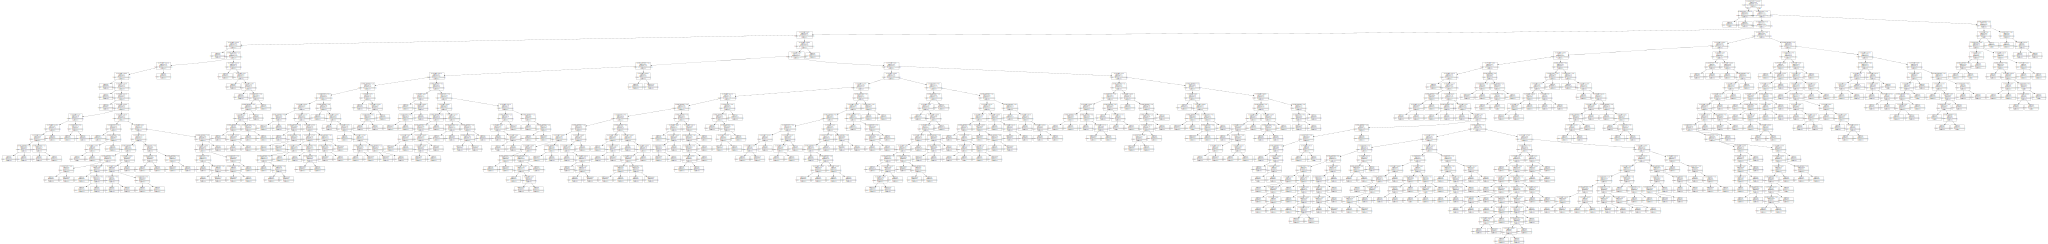

In [13]:
## Decision Tree Model
# Create Visualization of Decision Tree

# Set up Coloration

# Create Viz

dot_data = tree.export_graphviz(Treemodel, out_file=None,
                               feature_names=Xvalues.columns,
                               class_names=PolCon)
graph = gv.Source(dot_data)
graph.render("Decision Tree")
graph

Text(0,0.5,'Variable Name')

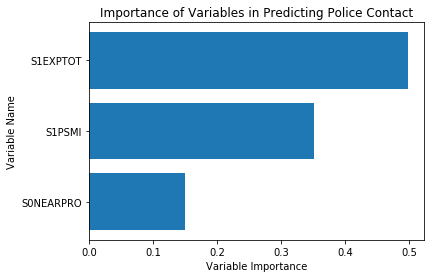

In [14]:
# Feature Importances
Vdf_dict = dict(zip(Xvalues.columns, Treemodel.feature_importances_))

# DataFrame for Feature Importances

Vdf = pd.DataFrame.from_dict(Vdf_dict, orient = 'index')
Vdf['VarName'] = Vdf.index
Vdf.columns = 'Importance', 'Name'
Vdf = Vdf.sort_values(by=['Importance', 'Name'])

# Barplot for Feature Importances
plt.figure()
plt.barh(Vdf.Name, Vdf.Importance)
plt.title('Importance of Variables in Predicting Police Contact')
plt.xlabel('Variable Importance')
plt.ylabel('Variable Name')

In [15]:
## Target Array and Feature Matrix of Contact Only

Xselect = PolConOnlyraw.drop(['CASEID', 'LINEID','S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI'], axis=1)
PolConSelect = PolConOnlyraw.S1PROJUS_PJPNUM
PolConSelect = PolConSelect.astype(str)
print('X shape:', Xselect.shape, '\ny shape:', PolConSelect.shape)

X shape: (231, 3) 
y shape: (231,)


In [16]:
## Decision Tree Select Model

selectmodel = tree.DecisionTreeClassifier()
selectmodel.fit(Xselect, PolConSelect)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
## Cross-Validation & Accuracy Score for Select Model
cross_val_score(selectmodel, Xselect, PolConSelect, cv=5)
scores = cross_val_score(selectmodel, Xselect, PolConSelect, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.09)


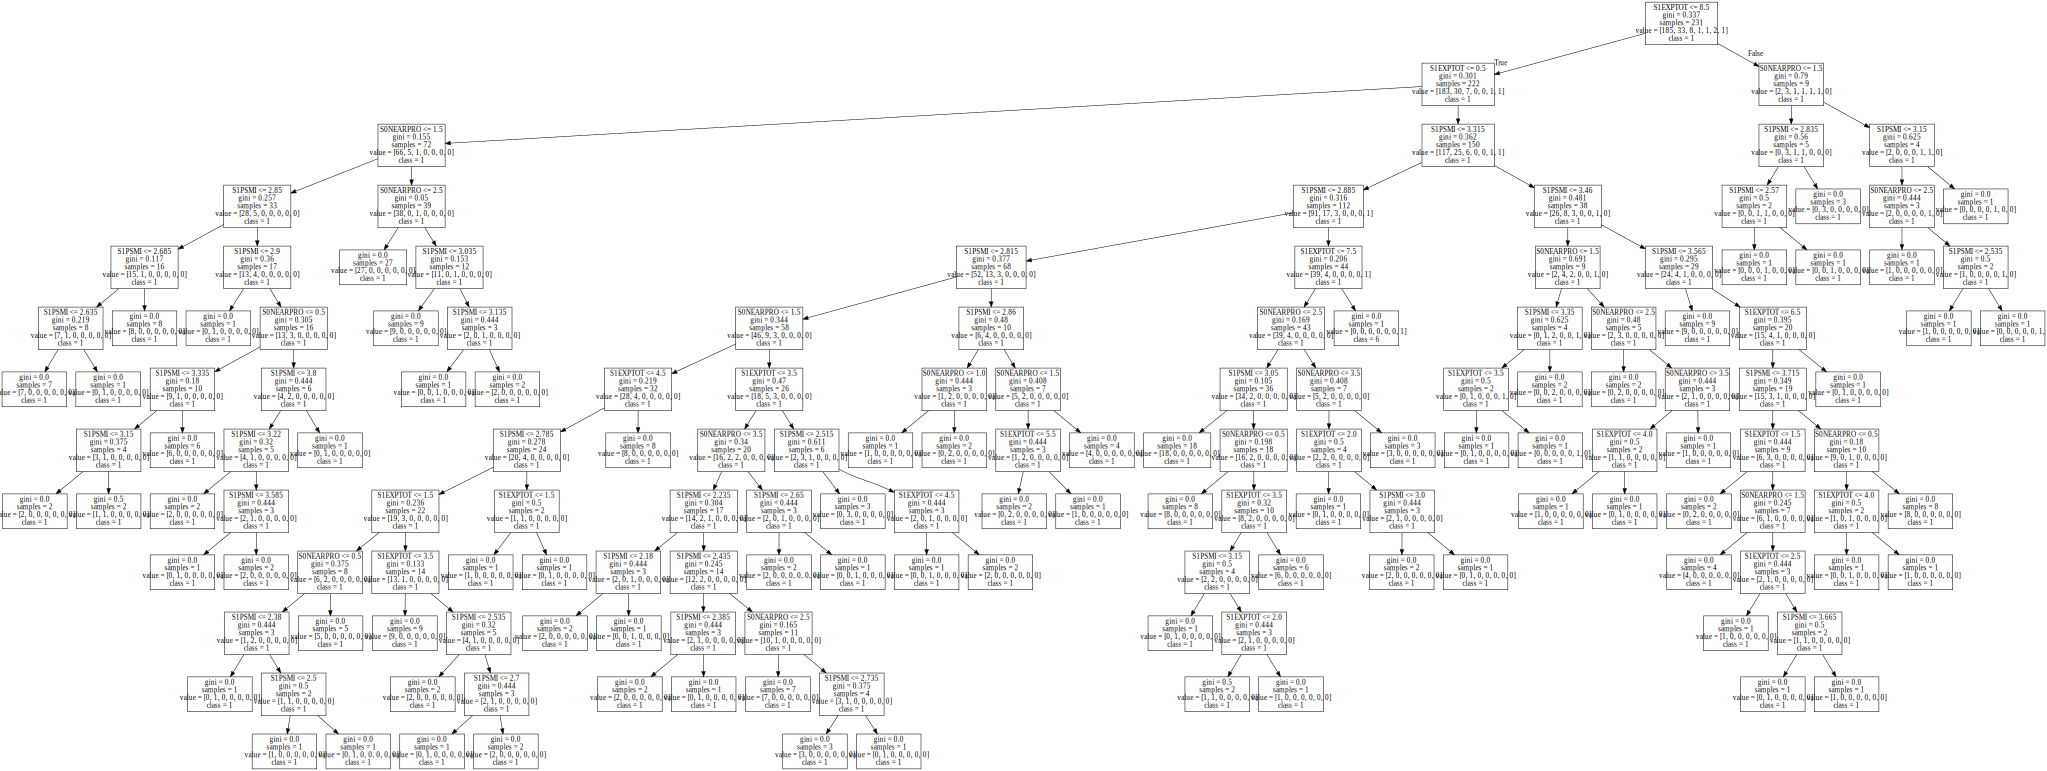

In [18]:
## Decision Tree Select Model Rendering
dot_data = tree.export_graphviz(selectmodel, out_file=None,
                               feature_names=Xselect.columns,
                               class_names=PolConSelect)
graph = gv.Source(dot_data)
graph.render("Decision Tree")
graph

Text(0,0.5,'Variable Name')

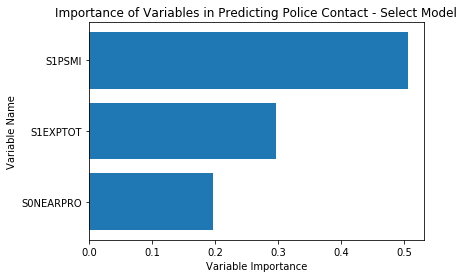

In [19]:
# Feature Importances - Select
Vdf_dict2 = dict(zip(Xselect.columns, selectmodel.feature_importances_))

# DataFrame for Feature Importances

Vdf2 = pd.DataFrame.from_dict(Vdf_dict2, orient = 'index')
Vdf2['VarName'] = Vdf2.index
Vdf2.columns = 'Importance', 'Name'
Vdf2 = Vdf2.sort_values(by=['Importance', 'Name'])

# Barplot for Feature Importances
plt.figure()
plt.barh(Vdf2.Name, Vdf2.Importance)
plt.title('Importance of Variables in Predicting Police Contact - Select Model')
plt.xlabel('Variable Importance')
plt.ylabel('Variable Name')

## References 

Forth, A., Kosson, D., & Hare, R. (2003). *The Hare Psychopathy Checklist: Youth Version, Technical Manual*. Multi-Health Systems, Inc.  New York.

Greenberger, E. & Bond, L. (1976). *Technical manual for the Psychosocial Maturity Inventory*. Unpublished manuscript, Program in Social Ecology, University of California, Irvine.

Greenberger, E., Josselson, R., Knerr, C., & Knerr, B. (1974). The measurement and structure of psychosocial maturity. *Journal of Youth and Adolescence, 4*, 127-143.

Mulvey, E. P. (2016). *Research on Pathways to Desistance [Maricopa County, AZ and Philadelphia County, PA]: Subject Measures, 2000-2010* (ICPSR 29961). [Data files and code book]. Retrieved from https://doi.org/10.3886/ICPSR29961.v2

Selner-Ohagan, M., Kindlon, D., Buka, S., Raudenbush, S., and Earls, F. (1998). Assessing exposure to violence in urban youth. *Journal of child Psychology and Psychiatry and allied Disciplines, 39*(2), 215-224.

